In [41]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, impute, inspection, model_selection, pipeline, cluster, metrics, decomposition
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set()

In [2]:
# Credit: https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)          # controls default text siz
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titl

#### K-fold coss-validation

In [3]:
def k_fold_validate(folds, model, features, target, model_type):
    kf = model_selection.KFold(n_splits=folds, shuffle=True, random_state=3)
    
    rec, prec, f1 = [], [], []
    imp_df = pd.DataFrame()
    for train_index, test_index in kf.split(features):
        # Retrieve the train and test sets
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # Standardize the data to optimize performance
        scaler = preprocessing.StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Fit the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluate the model
        rec += [metrics.recall_score(y_pred, y_test)]
        prec += [metrics.precision_score(y_pred, y_test)]
        f1 += [metrics.f1_score(y_pred, y_test)]
        
        # Store the feature importances for the fold
        if model_type == 'lrm':
            imps = abs(model.coef_[0])
        elif model_type == 'dtm' or model_type == 'rfm':
            imps = model.feature_importances_
        elif model_type == 'nbm':
            imps = inspection.permutation_importance(model, X_test, y_test).importances_mean
          
        imps = {k:v for k,v in enumerate(imps)}
        imp_df = imp_df.append(imps, ignore_index=True)
        
    print("recall    = {:.4f} ±{:.4f} {}".format(np.mean(rec), np.std(rec), rec))
    print("precision = {:.4f} ±{:.4f} {}".format(np.mean(prec), np.std(prec), prec))
    print("f1        = {:.4f} ±{:.4f} {}".format(np.mean(f1), np.std(f1), f1))
    
    scores = {'recall': [np.mean(rec), np.std(rec)],
              'precision': [np.mean(prec), np.std(prec)],
              'f1': [np.mean(f1), np.std(f1)],
              'feature_ranks': {k:v for k, v in enumerate(imp_df.mean(axis=0))}            
             }        
        
    return scores

## Data Exploration

### Large Dataset

In [4]:
# Import dataset
ldf = pd.read_csv("../data/dota2_matches_large.csv")
ldf.drop(columns='lobby_type', inplace=True)
print(ldf.shape)
ldf.head()

(209890, 203)


,radiant_win,dire_rating,dire_wins,dire_losses,radiant_rating,radiant_wins,radiant_losses,cluster_0,cluster_1,cluster_2,...,Monkey King,Dark Willow,Pangolier,Grimstroke,Hoodwink,Void Spirit,Snapfire,Mars,Dawnbreaker,Marci
0,True,917.940,9,19,1132.550,104,128,0.0,0.0,0.0,...,0,0,0,0,0,2,1,1,0,0
1,True,871.514,14,30,972.515,2,3,0.0,0.0,0.0,...,0,0,1,0,1,0,2,0,0,0
2,False,1132.550,104,128,917.940,9,19,0.0,0.0,0.0,...,0,0,0,0,0,2,2,0,0,0
3,True,972.515,2,3,871.514,14,30,0.0,0.0,0.0,...,0,0,0,0,0,0,1,1,0,0
4,True,1092.110,15,8,1093.280,142,121,0.0,0.0,0.0,...,0,0,0,2,0,0,0,0,0,0


In [5]:
# Create train and test sets
Xl = ldf.drop("radiant_win", axis=1)
yl = ldf["radiant_win"]

#### Explore the data

In [6]:
# Basic Shape
ldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209890 entries, 0 to 209889
Columns: 203 entries, radiant_win to Marci
dtypes: bool(1), float64(76), int64(126)
memory usage: 323.7 MB


In [7]:
# target class distribution
ldf['radiant_win'].value_counts(normalize=1)

True     0.5
False    0.5
Name: radiant_win, dtype: float64

In [12]:
#Store the importances of features
imp_large = pd.DataFrame()

## Classification Models

### Logistic Regression

In [14]:
# Large Dataset
lrm = LogisticRegression(max_iter=1000)
scores = k_fold_validate(5, lrm, Xl, yl, 'lrm')
imp_large = imp_large.append(scores['feature_ranks'], ignore_index=True)

recall    = 0.6412 ±0.0038 [0.6346712374422702, 0.6430981230696128, 0.6437375557030435, 0.6451796378803678, 0.6392002279635258]
precision = 0.6433 ±0.0047 [0.6350945733479442, 0.645860176568838, 0.6491228070175439, 0.6442025556081401, 0.642373043146239]
f1        = 0.6423 ±0.0041 [0.6348828348256811, 0.6444761904761905, 0.6464189655582795, 0.6446907265321588, 0.6407827080556084]


### Decision Tree

In [16]:
# Large Dataset
dtm = DecisionTreeClassifier()
scores = k_fold_validate(5, dtm, Xl, yl, 'dtm')
imp_large = imp_large.append(scores['feature_ranks'], ignore_index=True)

recall    = 0.6021 ±0.0023 [0.6001912960306074, 0.600663192799621, 0.5999148453022992, 0.6045350827153452, 0.6052744527636034]
precision = 0.6034 ±0.0031 [0.597932250226309, 0.6051061799093295, 0.6061953248243224, 0.6018457169900615, 0.6057655593738068]
f1        = 0.6027 ±0.0021 [0.5990596434282441, 0.6028765006537501, 0.6030387331478708, 0.6031874021723664, 0.6055199064907802]


### Random Forest

In [18]:
# Large Dataset
rfm = RandomForestClassifier()
scores = k_fold_validate(5, rfm, Xl, yl, 'rfm')
imp_large = imp_large.append(scores['feature_ranks'], ignore_index=True)

recall    = 0.6649 ±0.0023 [0.6605105920695274, 0.6651137962828165, 0.6660147655600646, 0.6655467913136625, 0.6673716309266181]
precision = 0.6474 ±0.0057 [0.6372861975320406, 0.6540682414698162, 0.6511783546058607, 0.64690014197823, 0.6476231386025201]
f1        = 0.6560 ±0.0039 [0.6486905916585839, 0.6595447764785141, 0.6585130039640337, 0.6560910050878371, 0.6573490940800311]


### Naive Bayes

In [20]:
# Large Dataset
nbm = GaussianNB()
scores = k_fold_validate(5, nbm, Xl, yl, 'nbm')
imp_large = imp_large.append(scores['feature_ranks'], ignore_index=True)

recall    = 0.5129 ±0.0356 [0.5441345051585785, 0.46875, 0.49806127333652467, 0.5643452642136275, 0.48942598187311176]
precision = 0.4101 ±0.3750 [0.6106055552908667, 0.01145311381531854, 0.9947416224484918, 0.42607666824420254, 0.007731958762886598]
f1        = 0.3525 ±0.2782 [0.5754568721655965, 0.022359901243769503, 0.6637745418587218, 0.4855594207588383, 0.01522341775125687]


#### Clean Up

In [22]:
#add column and row labels
imp_large['model'] = ['Logistic Regression', 'Decision Trees', 'Random Forest', 'Naive Bayes']
imp_large.set_index('model', inplace=True)
imp_large.columns = Xl.columns
imp_large.shape

(4, 202)

### PCA

#### Large Dataset

In [26]:
# Create train test splits
X_train, X_test, y_train, y_test = model_selection.train_test_split(Xl, yl, shuffle=True, test_size=0.3, random_state=7)
X_train.shape

(146923, 202)

 Perform PCA on features with 2, 3, 7 PCA components

In [27]:
def perform_pca(train: pd.DataFrame, test: pd.DataFrame, components: int):
    scl = preprocessing.StandardScaler()
    scl = scl.fit(train)
    scl_train = pd.DataFrame(scl.transform(train), index=train.index, columns=train.columns)
    scl_test = pd.DataFrame(scl.transform(test), index=test.index, columns=test.columns)

    pca = decomposition.PCA(n_components=components)
    pca = pca.fit(train)

    pca_train = pd.DataFrame(pca.transform(scl_train))
    pca_train.index = scl_train.index

    pca_test = pd.DataFrame(pca.transform(scl_test))
    pca_test.index = scl_test.index

    return pca_train, pca_test

X_train_pca_2, X_test_pca_2 = perform_pca(X_train, X_test, 2)
X_train_pca_3, X_test_pca_3 = perform_pca(X_train, X_test, 3)
X_train_pca_7, X_test_pca_7 = perform_pca(X_train, X_test, 7)

 Plot PCA 2

Text(0, 0.5, 'PCA Component 2')

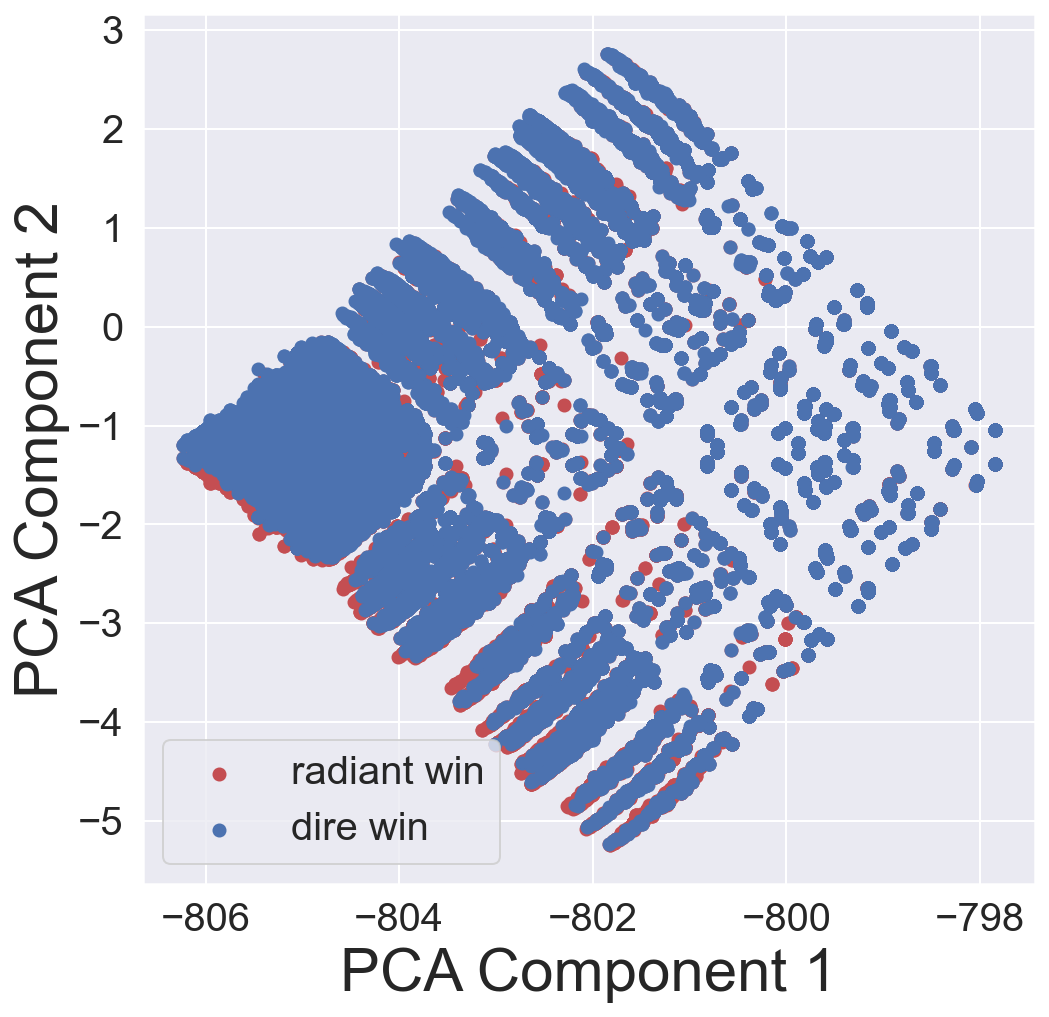

In [28]:
 #plot the PCA with color labels
fig, ax = plt.subplots(figsize=(8, 8))
color = ['r', 'b']
label = ['radiant win', 'dire win']

for t in {0, 1}:
    win_mask = y_train == t
    ax.scatter(X_train_pca_2.values[win_mask, 0], X_train_pca_2.values[win_mask, 1],
             label=label[t], color=color[t])

ax.legend()
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')

Plot PCA 3

C:\Users\Suchi\AppData\Local\Temp/ipykernel_5588/3321846068.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=48, azim=134)


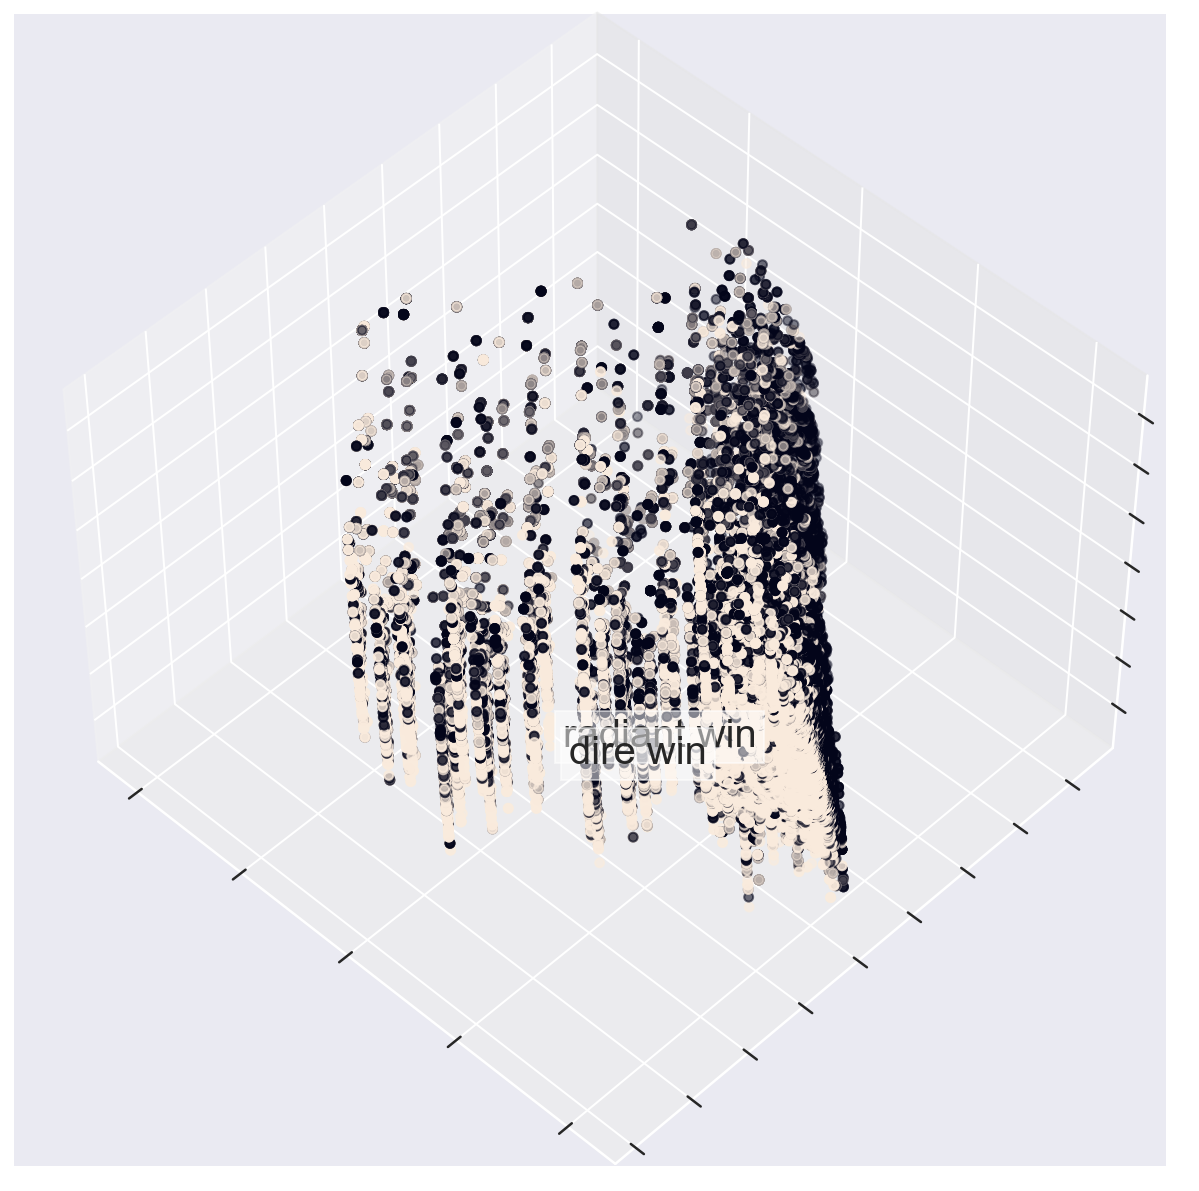

In [29]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, elev=48, azim=134)

for t in {0, 1}:
  ax.text3D(X_train_pca_3.values[y_train == t, 0].mean(),
            X_train_pca_3.values[y_train == t, 1].mean() + 1.5,
            X_train_pca_3.values[y_train == t, 2].mean(), label[t], horizontalalignment='center',
            bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

ax.scatter(X_train_pca_3.values[:, 0],
           X_train_pca_3.values[:, 1],
           X_train_pca_3.values[:, 2], c=y_train) #plotting the 3 clusters

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

### Large Dataset

In [30]:
# Import dataset
ldf = pd.read_csv("../data/dota2_matches_large_encoded.csv")
ldf.drop(columns='lobby_type', inplace=True)
print(ldf.shape)
ldf.head()

(209890, 325)


,radiant_win,dire_rating,dire_wins,dire_losses,radiant_rating,radiant_wins,radiant_losses,cluster_0,cluster_1,cluster_2,...,radiant_Monkey King,radiant_Dark Willow,radiant_Pangolier,radiant_Grimstroke,radiant_Hoodwink,radiant_Void Spirit,radiant_Snapfire,radiant_Mars,radiant_Dawnbreaker,radiant_Marci
0,True,917.940,9,19,1132.550,104,128,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,True,871.514,14,30,972.515,2,3,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
2,False,1132.550,104,128,917.940,9,19,0.0,0.0,0.0,...,0,0,0,0,0,1,1,0,0,0
3,True,972.515,2,3,871.514,14,30,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,True,1092.110,15,8,1093.280,142,121,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [31]:
# Create train and test sets
Xl = ldf.drop("radiant_win", axis=1)
yl = ldf["radiant_win"]

#### Lasso Regression

https://towardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a

In [38]:
#Create pipeline for grid search
pipe = pipeline.Pipeline([
                     ('scaler',preprocessing.StandardScaler()),
                     ('model',Lasso())
])

#Grid search for model with the most optimum hyperparameter
search = model_selection.GridSearchCV(pipe, {'model__alpha':np.arange(0.1,10,0.1)}, cv = 5, scoring="neg_mean_squared_error")
search.fit(Xl, yl)

# Retrieve feature importances from the optimized model
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)

In [40]:
importance

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.